In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal

# Hodgkin-Huxley model

In [2]:
# ion channel currents, uA/cm^2
def I_Na(V, E_Na, g_Na, m, h):
    return g_Na * m ** 3 * h * (V - E_Na)

def I_K(V, E_K, g_K, n):
    return g_K  * n ** 4 * (V - E_K)

def I_L(V, E_L, g_L):
    return g_L * (V - E_L)

In [3]:
# channel gating kinetics represented as functions of membrane voltage
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

In [4]:
# Hodgkin-Huxley ode system
def hh(t, y, *args):
    V, m, h, n = y
    C_m, g_Na, E_Na, g_K, E_K, g_L, E_L = args
    return [((I_inj(t)
              - I_Na(V, E_Na, g_Na, m, h)
              - I_K(V, E_K, g_K, n)
              - I_L(V, E_L, g_L)) / C_m),
            alpha_m(V) * (1.0 - m) - beta_m(V) * m,
            alpha_h(V) * (1.0 - h) - beta_h(V) * h,
            alpha_n(V) * (1.0 - n) - beta_n(V) * n]

In [5]:
# parameters
# N.B. cell area  is assumed to be 1000 um^2
C_m = 1.0  # uF/cm^2
g_Na = 120.0  # mS/cm^2
E_Na = 50.0  # mV
g_K = 36.0  # mS/cm^2
E_K = -77.0  # mV
g_L = 0.3  # mS/cm^2
E_L = - 54.387  # mV

# time domain
t = np.arange(0.0, 450.0, 0.01)  # ms

# initial conditions
y0 = [-65, 0.05, 0.6, 0.32]  # V(t=0), m(t=0), h(t=0), n(t=0)

# dc synaptic stimulus solution

In [6]:
# synaptic dc current, uA/cm^2 or nA for a surface area of 1000.0 um^2
def I_inj(t):
    return 10 * (t > 100) - 10 * (t > 200) + 35 * (t > 300) - 35 * (t > 400)

In [7]:
# solution of `hh` via LSODA
sol = solve_ivp(hh,
                t_span = (t[0], t[-1]),
                y0=y0,
                method='LSODA',
                t_eval=t,
                vectorized=True,
                args=(C_m, g_Na, E_Na, g_K, E_K, g_L, E_L))

# unpack the solution
V, m, h, n = sol.y

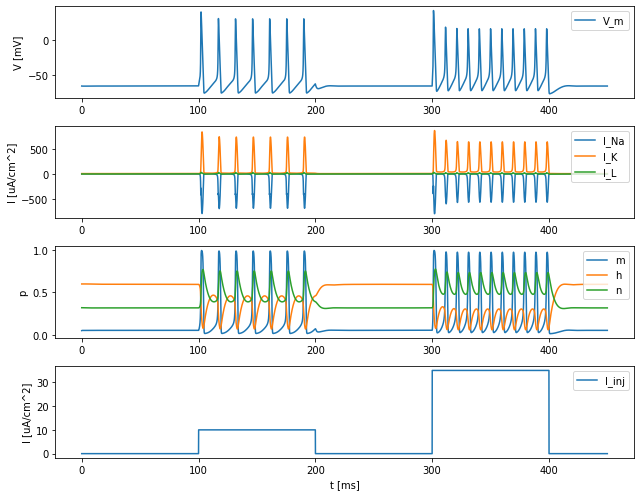

In [8]:
# visualize traces, ion channel currents, gating variables, and stimulus
plt.figure(figsize=(9, 7))
plt.subplot(411)
plt.plot(t, V)
plt.legend(['V_m'])
plt.ylabel('V [mV]')
plt.subplot(412)
plt.plot(t, I_Na(V, E_Na, g_Na, m, h),
         t, I_K(V, E_K, g_K, n),
         t, I_L(V, E_L, g_L))
plt.legend(['I_Na', 'I_K', 'I_L'])
plt.ylabel('I [uA/cm^2]')
plt.subplot(413)
plt.plot(t, m, t, h, t, n)
plt.legend(['m', 'h', 'n'])
plt.ylabel('p')
plt.subplot(414)
plt.plot(t, I_inj(t))
plt.legend(['I_inj'])
plt.xlabel('t [ms]')
plt.ylabel('I [uA/cm^2]')
plt.tight_layout()
plt.show()

# Bifurcations

In [9]:
# notice that A is the variable now
def I_inj(t):
    return A * (t > 100) - A * (t > 400) 

In [10]:
# compute bifurcation diagram w.r.t. changes in the current amplitude
# N.B. non-optimized code -> very slow to compute
n_peaks = []  # number of spikes
m_isi = []  # mean inter-spike interval, ms
isi = []  # inters-spike interval, ms
V_min = []  # min value of the action potential
V_max = []  # max value of the action potential
A_range = np.arange(0, 50, 0.1)  # current amplitude range
for A in A_range:
    sol = solve_ivp(hh,
                    t_span = (t[0], t[-1]),
                    y0=y0,
                    method='LSODA',
                    t_eval=t,
                    vectorized=True,
                    args=(C_m, g_Na, E_Na, g_K, E_K, g_L, E_L))
    V, _, _, _ = sol.y
    spike_events_idx = signal.find_peaks(V, height=0)[0]
    n_peaks.append(spike_events_idx.size)
    if spike_events_idx.size > 1:
        isi.append(np.diff(t[spike_events_idx]).tolist())
        m_isi.append(np.nanmean(np.diff(t[spike_events_idx])))
    else:
        isi.append(0)
        m_isi.append(0)
    V_min.append(V.min())
    V_max.append(V.max())

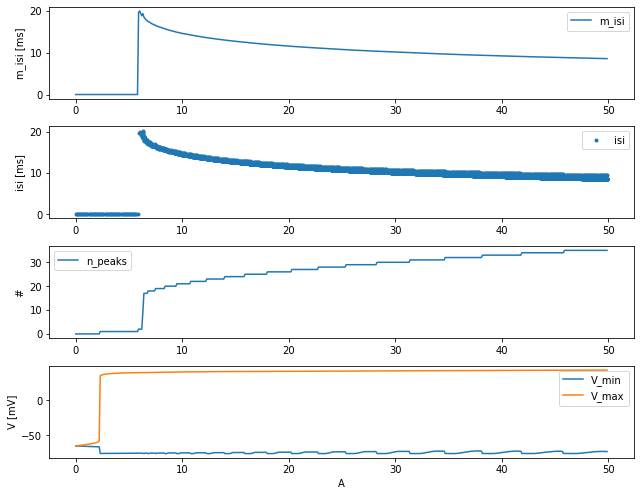

In [11]:
# visualize bifurcation diagrams
plt.figure(figsize=(9, 7))
plt.subplot(411)
plt.plot(A_range, m_isi)
plt.legend(['m_isi'])
plt.ylabel('m_isi [ms]')
plt.subplot(412)
for A, isi_per_A in zip(A_range, isi):
    if isinstance(isi_per_A, (list, )):
        plt.plot([A] * len(isi_per_A), isi_per_A, 'C0.')
    else:
        plt.plot(A, isi_per_A, 'C0.')
plt.legend(['isi'])
plt.ylabel('isi [ms]')
plt.subplot(413)
plt.plot(A_range, n_peaks)
plt.legend(['n_peaks'])
plt.ylabel('#')
plt.subplot(414)
plt.plot(A_range, V_min, A_range, V_max)
plt.legend(['V_min', 'V_max'])
plt.xlabel('A')
plt.ylabel('V [mV]')
plt.tight_layout()
plt.show()

# Hyperpolarizing current injections

In [12]:
# current injection lasts for a brief interval of 10 ms
def I_inj(t):
    return A * (t > 100) - A * (t > 110)

In [13]:
A = -10  # "negative" current will lead to hyperolarization of the cell

# solving again via LSODA
sol = solve_ivp(hh,
                t_span = (t[0], t[-1]),
                y0=y0,
                method='LSODA',
                t_eval=t,
                vectorized=True,
                args=(C_m, g_Na, E_Na, g_K, E_K, g_L, E_L))

# unpack the solution
V, m, h, n = sol.y

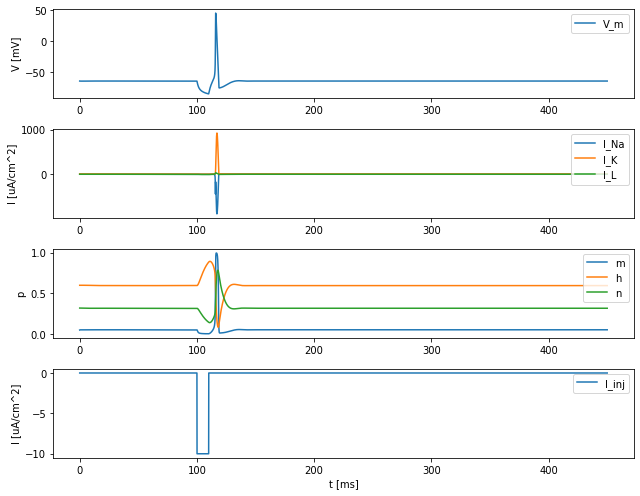

In [14]:
# visualize traces, ion channel currents, gating variables, and stimulus
plt.figure(figsize=(9, 7))
plt.subplot(411)
plt.plot(t, V)
plt.legend(['V_m'])
plt.ylabel('V [mV]')
plt.subplot(412)
plt.plot(t, I_Na(V, E_Na, g_Na, m, h),
         t, I_K(V, E_K, g_K, n),
         t, I_L(V, E_L, g_L))
plt.legend(['I_Na', 'I_K', 'I_L'])
plt.ylabel('I [uA/cm^2]')
plt.subplot(413)
plt.plot(t, m, t, h, t, n)
plt.legend(['m', 'h', 'n'])
plt.ylabel('p')
plt.subplot(414)
plt.plot(t, I_inj(t))
plt.legend(['I_inj'])
plt.xlabel('t [ms]')
plt.ylabel('I [uA/cm^2]')
plt.tight_layout()
plt.show()

# Filtering the neural noise

In [15]:
def I_inj(t):
    return 10 * (t > 50)

In [16]:
sol = solve_ivp(hh,
                t_span = (t[0], t[-1]),
                y0=y0,
                method='LSODA',
                t_eval=t,
                vectorized=True,
                args=(C_m, g_Na, E_Na, g_K, E_K, g_L, E_L))
V, m, h, n = sol.y

In [17]:
# generate 100 voltage traces with increasing noise
np.random.seed(42)
n_simulations = 40
noise_factor = np.linspace(0, 40, n_simulations)  # noise factor range
neural_noise = np.random.randn(n_simulations, t.size)
traces = np.zeros((n_simulations, t.size))
for i in range(n_simulations):
    traces[i] = V + noise_factor[i] * neural_noise[i, :]

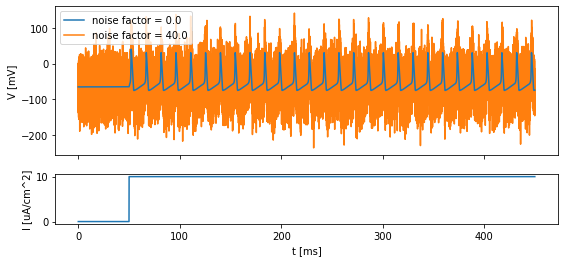

In [18]:
# visualize traces with and without added white noise and stimulus current
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
ax[0].plot(t, traces[0], label=f'noise factor = {noise_factor[0]}', zorder=2)
ax[0].plot(t, traces[-1], label=f'noise factor = {noise_factor[-1]}', zorder=1)
ax[0].set_ylabel('V [mV]')
ax[0].legend()
ax[1].plot(t, I_inj(t))
ax[1].set_xlabel('t [ms]')
ax[1].set_ylabel('I [uA/cm^2]');

In [19]:
# trace with the largest noise factor, i.e., with the lowest SNR
V_noisy = traces[-1, :]

In [20]:
# apply digital 3rd order Butterworth filter on the noisy trace
b, a = signal.butter(3, 0.01)
zi = signal.lfilter_zi(b, a)
V_noisy_filtered, _ = signal.lfilter(b, a, V_noisy, zi=zi*V_noisy[0])

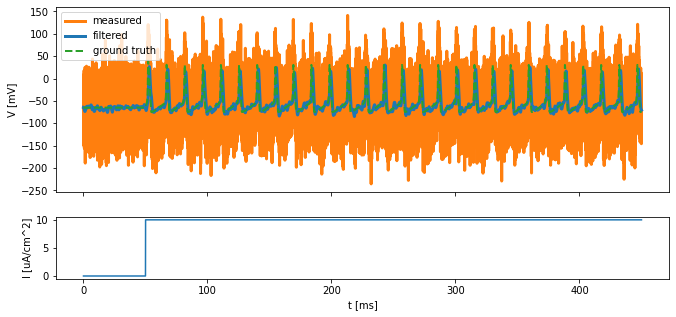

In [22]:
# visualize "measured" noisy trace, filtered trace and ground truth
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [3, 1]}, figsize=(11, 5))
ax[0].plot(t, V_noisy, lw=3, c='C1', label='measured')
ax[0].plot(t, V_noisy_filtered, lw=3, c='C0', label='filtered')
ax[0].plot(t, V, 'C2--', lw=2, label='ground truth')
ax[0].set_ylabel('V [mV]')
ax[0].legend()
ax[1].plot(t, I_inj(t))
ax[1].set_xlabel('t [ms]')
ax[1].set_ylabel('I [uA/cm^2]');

In [25]:
# store the data
np.save(os.path.join('data', 'inp_trace'), I_inj(t))
np.save(os.path.join('data', 'out_trace_measured'), V_noisy)
np.save(os.path.join('data', 'out_trace_filtered'), V_noisy_filtered)
np.save(os.path.join('data', 'out_trace_ground_truth'), V)